In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import scipy.optimize
from scipy.linalg import cholesky
from numpy.linalg import inv
from numpy.linalg import pinv


from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit

import statistics

import random


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


print(uproot.__version__)
print(pd.__version__)

3.14.4
2.2.2


In [2]:
# In this notebook, we will compare the ns time distribtions for different event selections.
# Currently, only data is included, this can eventually be expanded to also include MC.
# The times could also be "recalculated" and/or "recalibrated" follwing different methods to see if/how the behavior changes.

In [3]:
# put the paths to your data files here

bnb_data_file = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_reco2_BNB_beam_on_reco2_hist_goodruns_62221062_snapshot_goodruns.root"

numi_data_file = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/SURPRISE_Test_Samples_v10_04_07_05_Run4b_wirecell_standalone_reco2_numi_beam_on_reco2_hist_goodruns_62221095_snapshot_goodruns.root"


In [4]:
bnb_gap = 18.936
numi_gap = 18.831

In [5]:
#function to calculate the angle wrt the beam
def get_angle(momentum_0,momentum_1,momentum_2):
    momentum_perp = np.sqrt(momentum_0 * momentum_0 + momentum_1 * momentum_1)
    # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
    theta = np.arctan2(momentum_perp, momentum_2)
    phi = np.arctan2(momentum_0, momentum_1)
    return theta, phi

def get_bin_centers(x):
    centers = []
    for i in range(len(x)-1): centers.append( x[i] + (x[i+1]-x[i])/2 )
    return centers

def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + offset


In [6]:
#Definitions for some slections and signals that are usefull to examine
#numucc signal
sig_query = "truth_isCC==1 and truth_nuPdg==14"
#numucc selection
sel_query = "numu_cc_flag>=0 and numu_score > 0.9"
# "NC" selection. mostly just the base for the cut based NCpi0 selection
NC_query = "cosmict_flag==0 and numu_score < 0"
#CC pi0 cut based selection
CCpi0_query = sel_query + ' and ((kine_pio_flag==1 and kine_pio_vtx_dis < 9 ) and kine_pio_energy_1* em_charge_scale > 40 and kine_pio_energy_2* em_charge_scale > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and pio_mass > 22 and pio_mass < 300)'
#NC pi0 cut based selection
NCpi0_query = NC_query + ' and ((kine_pio_flag==1 and kine_pio_vtx_dis < 9 or kine_pio_flag==2) and kine_pio_energy_1* em_charge_scale > 40 and kine_pio_energy_2* em_charge_scale > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and pio_mass > 22 and pio_mass < 300)'
#CC+NC pi0 cut based selection
pi0_query = '((kine_pio_flag==1 and kine_pio_vtx_dis < 9 or kine_pio_flag==2) and kine_pio_energy_1* em_charge_scale > 40 and kine_pio_energy_2* em_charge_scale > 25 and kine_pio_dis_1 < 110 and kine_pio_dis_2 < 120 and kine_pio_angle > 0 and kine_pio_angle < 174  and pio_mass > 22 and pio_mass < 300)'
#NC pi0 BDT based selection
NCpi0_bdt_query = 'nc_pio_score > 1.816 and kine_pio_energy_1 > 0 and kine_pio_energy_2 > 0 and match_isFC==1'

em_charge_scale = 0.95


In [7]:
#Variables that are loaded directly out of the files.
#There are more here than are needed for these compasisons, they can be removed if memory becomes an issue.
bdt_vars = [
    "mip_energy",
    "mip_angle_beam", 
    "spt_angle_vertical",
    "nue_score", 
    "numu_score", 
    "numu_cc_flag",
    "numu_1_score",
    "numu_cc_3_track_length",
    "numu_cc_3_max_length_all",
    "cosmict_2_dQ_dx_front",
    "cosmict_2_dQ_dx_end",
    "cosmict_2_angle_beam",
    "cosmict_2_phi",
    "numu_cc_3_max_length",
    "numu_cc_3_max_muon_length",

    "numu_cc_flag_1",
    "numu_cc_flag_2",
    "numu_cc_flag_3",
    "cosmict_flag",
    
    "numu_cc_1_length",
    "numu_cc_1_direct_length",
    "numu_cc_2_length",
    "numu_cc_2_total_length",

    #"nc_pio_score"
]

bdt_vars_slim = [
    "mip_energy",
    "mip_angle_beam", 
    "spt_angle_vertical",
    "nue_score", 
    "numu_score", 
    "numu_cc_flag",
    "numu_1_score",
    "numu_cc_3_track_length",
    "numu_cc_3_max_length_all",
    "cosmict_2_dQ_dx_front",
    "cosmict_2_dQ_dx_end",
    "cosmict_2_angle_beam",
    "cosmict_2_phi",
    "numu_cc_3_max_length",
    "numu_cc_3_max_muon_length",

    "numu_cc_flag_1",
    "numu_cc_flag_2",
    "numu_cc_flag_3",
    "cosmict_flag",
    
    "numu_cc_1_length",
    "numu_cc_1_direct_length",
    "numu_cc_2_length",
    "numu_cc_2_total_length",

    #"nc_pio_score"
]

kine_vars_data = ["kine_particle_type", "kine_energy_particle", "kine_reco_add_energy", "kine_energy_info",
                 "kine_pio_mass",
                    "kine_pio_flag",
                    "kine_pio_vtx_dis",
                    "kine_pio_energy_1",
                    "kine_pio_theta_1",
                    "kine_pio_phi_1",
                    "kine_pio_dis_1",
                    "kine_pio_energy_2",
                    "kine_pio_theta_2",
                    "kine_pio_phi_2",
                    "kine_pio_dis_2",
                    "kine_pio_angle"]
kine_vars = ["kine_particle_type", "kine_energy_particle", "kine_reco_add_energy", "kine_energy_info"]
pf_eval_data_variables = ["reco_muonMomentum","reco_protonMomentum",'reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ', 'reco_Nproton', 'reco_Ntrack', 'reco_id', 'reco_pdg','reco_mother','reco_startMomentum', 'reco_endMomentum','reco_startXYZT','reco_endXYZT']


#pf_eval_data_variables = [
#    'reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ', 
#    'reco_showervtxX', 'reco_showervtxY', 'reco_showervtxZ', 'reco_showerKE', 
#    'reco_muonvtxX', 'reco_muonvtxY', 'reco_muonvtxZ', 
#    'reco_muonMomentum', 'reco_protonMomentum', 'reco_showerMomentum', 
#    'reco_Nproton', 
#    'reco_Nproton', 
#    'reco_id', 'reco_pdg', 'reco_process', 'reco_mother', 'reco_startXYZT', 'reco_endXYZT', 'reco_startMomentum', 'reco_endMomentum', 'reco_daughters']
eval_data_variables = [
    "run",
    "subrun",
    "event",
    'flash_found', 
    'flash_time', 
    'flash_found_asInt', 'match_found_asInt', 
    'flash_measPe', 'flash_predPe', 
    'match_found', 'match_type', 'match_isFC', 'match_isTgm', 'match_notFC_FV', 'match_notFC_SP','match_notFC_DC', 'match_chargeU', 'match_chargeV', 'match_chargeY', 'match_energyY', 'light_mismatch', 'match_charge', 'match_energy', 
    'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead', 'stm_clusterlength']


eval_data_variables_notbool = [
'flash_time', 
'stm_clusterlength'
 ]

eval_data_variables_energy = [
'match_energyY',
 'match_energy']

eval_data_variables_pe = [
'flash_measPe', 'flash_predPe']

eval_data_variables_charge = [
'match_chargeU', 'match_chargeV', 'match_chargeY','match_charge']

eval_data_variables_cat = [
'match_type','stm_eventtype']

eval_data_variables_bool = [
'flash_found','flash_found_asInt', 'match_found_asInt','match_found','match_isFC',
'match_isTgm', 'match_notFC_FV', 'match_notFC_SP','match_notFC_DC','light_mismatch',
'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead']

In [8]:
# Load in the BNB data file into a pandas dataframe
f_data_run1 = uproot.open(bnb_data_file)["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables, flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(["evtTimeNS","RWM_Time","PMT_Time","PMT_ID",'PMT_TimeDP']+pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_vars_data, flatten=False)
f_data_run1B_pot = f_data_run1["T_pot"].pandas.df(["pot_tor875good","runNo",'subRunNo'], flatten=False)
data_run1B_pot = np.sum(f_data_run1B_pot["pot_tor875good"].to_numpy())
print(data_run1B_pot)
data_run4b_super_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine

data_run4b_super_df["rse_num"] = (data_run4b_super_df["run"].to_numpy() * 100_000_000_000
                         + data_run4b_super_df["subrun"].to_numpy() * 1_000_000
                         + data_run4b_super_df["event"].to_numpy())

print(data_run4b_super_df.shape[0])
data_run4b_super_df = data_run4b_super_df.drop_duplicates(subset=['rse_num'])
print(data_run4b_super_df.shape[0])

#Set a variable saying this is not EXT data
data_run4b_super_df["isEXT"] = [0 for i in range(data_run4b_super_df.shape[0])]
#Set a variable saying this is not a dirt overlay
data_run4b_super_df["isDirt"] = [0 for i in range(data_run4b_super_df.shape[0])]
#Set a variable indicating the file type
data_run4b_super_df["category"] = ["data" for i in range(data_run4b_super_df.shape[0])]
#Set a vairable saying which run number this is.
#You can cut on this variable to do un by run comparisons.
data_run4b_super_df["run_num"] = [4 for i in range(data_run4b_super_df.shape[0])]

3070117.733191382
348245
257846


In [9]:
#Get the reconstructed neutrino energy, for data we need to apply a scaling to the shower energy
corrected_kine_reco_Enus = []
energy_info_lists = data_run4b_super_df["kine_energy_info"].to_numpy()
energy_lists = data_run4b_super_df["kine_energy_particle"].to_numpy()
pdg_lists = data_run4b_super_df["kine_particle_type"].to_numpy()
add_energies = data_run4b_super_df["kine_reco_add_energy"].to_numpy()
for i in tqdm(range(data_run4b_super_df.shape[0])):
    corrected_kine_reco_Enu = 0.
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    energy_info_list = energy_info_lists[i]
    for j in range(len(energy_list)):
        if energy_info_list[j] == 2 and pdg_list[j] == 11:
            corrected_kine_reco_Enu += em_charge_scale * energy_list[j]
        else:
            corrected_kine_reco_Enu += energy_list[j]
    corrected_kine_reco_Enu += add_energies[i]
    
    corrected_kine_reco_Enus.append(corrected_kine_reco_Enu) 

data_run4b_super_df["kine_reco_Enu"] = corrected_kine_reco_Enus

100%|███████████████████████████████| 257846/257846 [00:00<00:00, 377509.83it/s]


In [10]:
em_charge_scale = 0.95
data_run4b_super_df["pio_mass"] = data_run4b_super_df['kine_pio_mass'].to_numpy()* em_charge_scale
data_run4b_super_df["em_charge_scale"] = np.ones_like(data_run4b_super_df['kine_pio_mass'].to_numpy())* em_charge_scale

In [11]:
#get the muon and leading proton info out of the pfeval tree
mu0 = data_run4b_super_df["reco_muonMomentum[0]"].to_numpy()
mu1 = data_run4b_super_df["reco_muonMomentum[1]"].to_numpy()
mu2 = data_run4b_super_df["reco_muonMomentum[2]"].to_numpy()
mu3 = data_run4b_super_df["reco_muonMomentum[3]"].to_numpy()

p0 = data_run4b_super_df["reco_protonMomentum[0]"].to_numpy()
p1 = data_run4b_super_df["reco_protonMomentum[1]"].to_numpy()
p2 = data_run4b_super_df["reco_protonMomentum[2]"].to_numpy()
p3 = data_run4b_super_df["reco_protonMomentum[3]"].to_numpy()

kine_reco_Enu = data_run4b_super_df["kine_reco_Enu"].to_numpy()

mu_thetas = []
mu_phis = []
mu_costhetas = []
mu_cosphis = []
reco_Emuon = []

p_thetas = []
p_phis = []
p_costhetas = []
p_cosphis = []
reco_Eproton = []

Ehadron = []

for i in range(len(mu3)):
    if(mu3[i]<=0): 
        mu_theta = np.nan
        mu_phi = np.nan
        Ehadron.append(kine_reco_Enu[i])
    else: 
        mu_theta, mu_phi = get_angle(mu0[i], mu1[i], mu2[i])
        Ehadron.append(kine_reco_Enu[i]-mu3[i]*1000)
    mu_thetas.append(mu_theta)
    mu_phis.append(mu_phi)
    mu_costhetas.append(np.cos(mu_theta))
    mu_cosphis.append(np.cos(mu_phi))
    reco_Emuon.append(mu3[i]*1000)
    
    if(p3[i]<=0): 
        p_theta = np.nan
        p_phi = np.nan
        reco_Eproton.append(0)
        
    else: 
        p_theta, p_phi = get_angle(p0[i], p1[i], p2[i])
        reco_Eproton.append(p3[i]*1000-938.27)
    p_thetas.append(p_theta)
    p_phis.append(p_phi)
    p_costhetas.append(np.cos(p_theta))
    p_cosphis.append(np.cos(p_phi))
    
    
    
    
    
data_run4b_super_df["reco_muon_theta"] = mu_thetas
data_run4b_super_df["reco_muon_phi"] = mu_phis
data_run4b_super_df["reco_muon_costheta"] = mu_costhetas
data_run4b_super_df["reco_muon_cosphi"] = mu_cosphis 
data_run4b_super_df["reco_Emuon"] = reco_Emuon

data_run4b_super_df["reco_proton_theta"] = p_thetas
data_run4b_super_df["reco_proton_phi"] = p_phis
data_run4b_super_df["reco_proton_costheta"] = p_costhetas
data_run4b_super_df["reco_proton_cosphi"] = p_cosphis 
data_run4b_super_df["reco_Eproton"] = reco_Eproton

data_run4b_super_df["Ehadron"] = Ehadron

In [12]:
#merge everything into a single peak with the run dependent corrections
run = data_run4b_super_df["run"].to_numpy()
evtTimeNS = data_run4b_super_df["evtTimeNS"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    gap=bnb_gap
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.3 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    if(TThelp>=0 and TThelp<gap*81.0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

data_run4b_super_df["merge_time"] = new_times

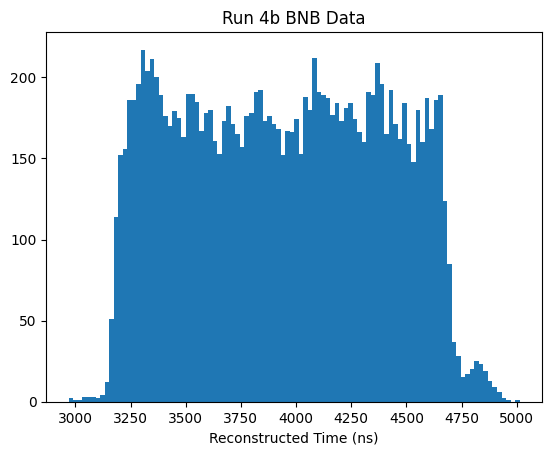

In [13]:
#Check the unmerged beamspill distribution
plt.figure()
plt.title("Run 4b BNB Data")
plt.hist(data_run4b_super_df.query("evtTimeNS>0 and evtTimeNS<5500")["evtTimeNS"].to_numpy(),bins=100)
plt.xlabel('Reconstructed Time (ns)')
plt.show()

numuCC: Gaussian      mean: -0.0491   std: 2.7182   C: 0.0089
CCpi0: Gaussian      mean: -0.4101   std: 2.7587   C: 0.0099
NCpi0: Gaussian      mean: -1.2237   std: 3.6324   C: 0.0169
loose nueCC: Gaussian      mean: -1.124   std: 4.1132   C: -0.0038


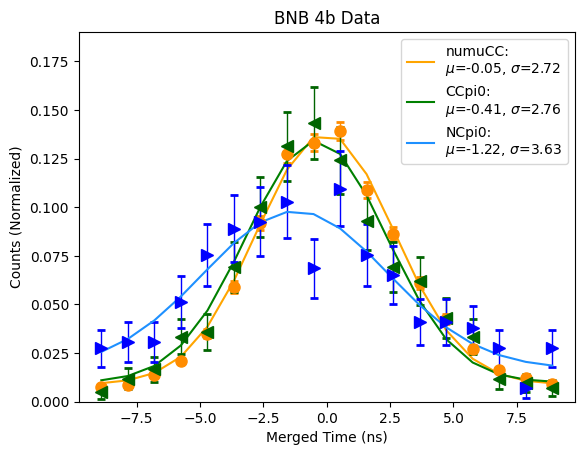

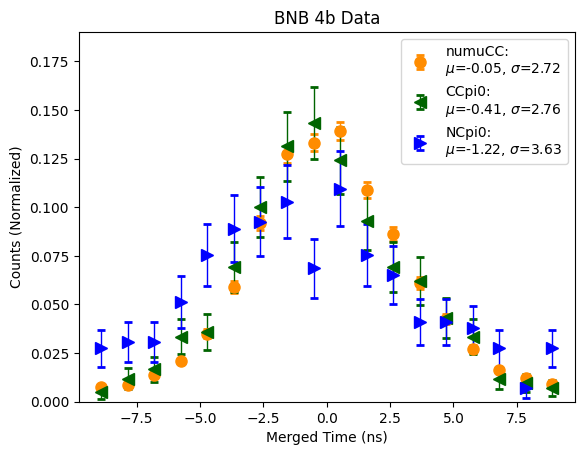

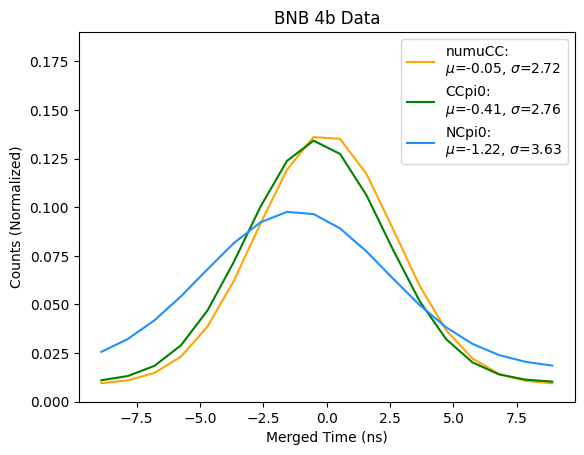

In [14]:
#plot the merged time distributions for numuCC events 
#compare this to CCpi0, NCpi0, and nueCC events

nbins = 18

data_numuCC = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9")["merge_time"].to_numpy()
norm1 = len(data_numuCC)
y,xbins = np.histogram(data_numuCC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCC: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 18

data_CCpi0 = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query(CCpi0_query)["merge_time"].to_numpy()
norm2 = len(data_CCpi0)
y2,xbins = np.histogram(data_CCpi0,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("CCpi0: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

nbins = 18

data_NCpi0 = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query(NCpi0_query)["merge_time"].to_numpy()
norm3 = len(data_NCpi0)
y3,xbins = np.histogram(data_NCpi0,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x3 = x
popt3,pcov3 = curve_fit(gaus,x,y3/norm3)
print("NCpi0: Gaussian      mean:",round(popt3[1],4),"  std:",round(popt3[2],4),"  C:",round(popt3[3],4))


data_nueCC = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("nue_score>2")["merge_time"].to_numpy()
norm4 = len(data_nueCC)
y4,xbins = np.histogram(data_nueCC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x4 = x
popt4,pcov4 = curve_fit(gaus,x,y4/norm4)
print("loose nueCC: Gaussian      mean:",round(popt4[1],4),"  std:",round(popt4[2],4),"  C:",round(popt4[3],4))


plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.errorbar(x3,y3/norm3,yerr=np.sqrt(y3)/norm3,ms=8, lw=1,fmt='>',ecolor = 'blue',color='blue', capsize=3, capthick=2)
plt.plot(x3,gaus(x3,*popt3),color='dodgerblue',label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.errorbar(x4,y4/norm4,yerr=np.sqrt(y4)/norm4,ms=8, lw=1,fmt='>',ecolor = 'magenta',color='magenta', capsize=3, capthick=2)
#plt.plot(x4,gaus(x4,*popt4),color='magenta',label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")


plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.errorbar(x3,y3/norm3,yerr=np.sqrt(y3)/norm3,ms=8, lw=1,fmt='>',ecolor = 'blue',color='blue', capsize=3, capthick=2,label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.errorbar(x4,y4/norm4,yerr=np.sqrt(y4)/norm4,ms=8, lw=1,fmt='>',ecolor = 'magenta',color='magenta', capsize=3, capthick=2,label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.plot(x3,gaus(x3,*popt3),color='dodgerblue',label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.plot(x4,gaus(x4,*popt4),color='magenta',label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

numuCCNp: Gaussian      mean: 0.0633   std: 2.6859   C: 0.0068
numuCC0p: Gaussian      mean: -0.2186   std: 2.7602   C: 0.0115


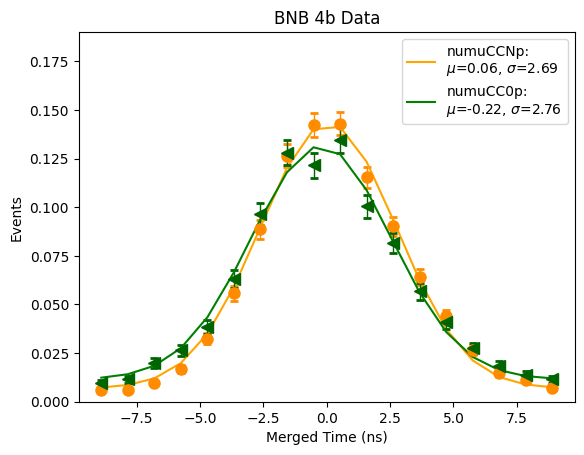

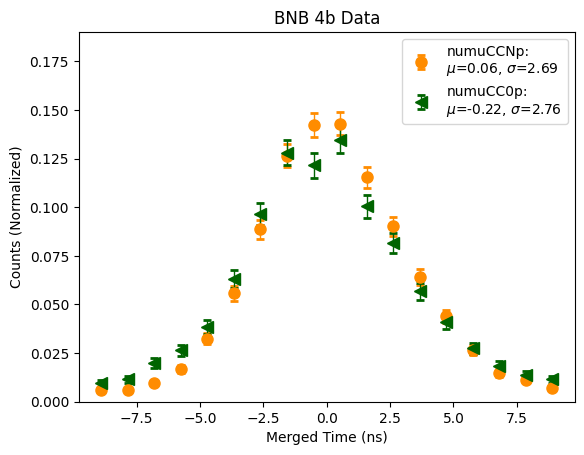

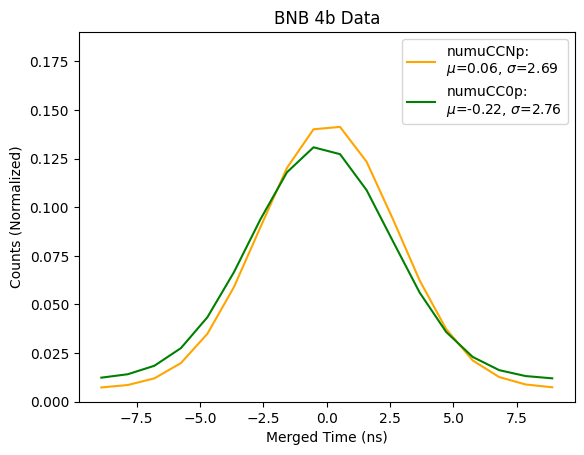

In [15]:
#plot the merged time distributions for numuCC events with a visible proton (Np)
#compare this to events without a visible proton (0p)

nbins = 18

data_numuCCNp = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and reco_Eproton>35")["merge_time"].to_numpy()
norm1 = len(data_numuCCNp)
y,xbins = np.histogram(data_numuCCNp,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCCNp: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 18

data_numuCC0p = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and reco_Eproton<35")["merge_time"].to_numpy()
norm2 = len(data_numuCC0p)
y2,xbins = np.histogram(data_numuCC0p,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("numuCC0p: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

numuCC FC: Gaussian      mean: 0.1262   std: 2.6364   C: 0.006
numuCC PC: Gaussian      mean: -0.1553   std: 2.7744   C: 0.0101


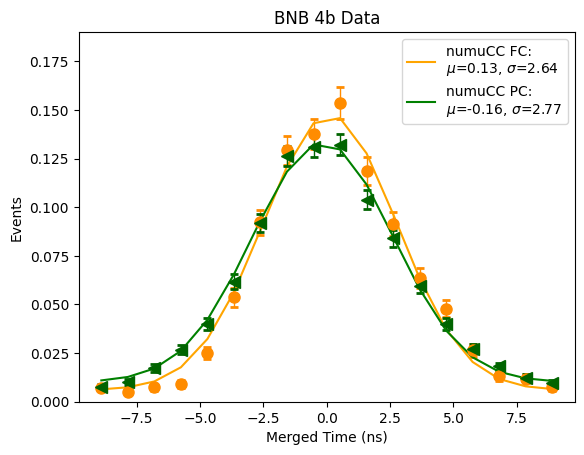

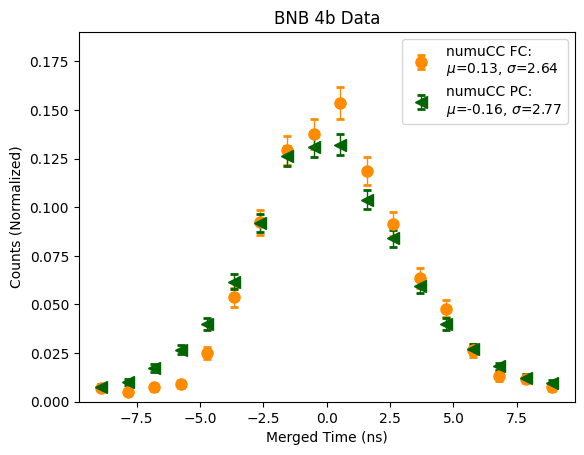

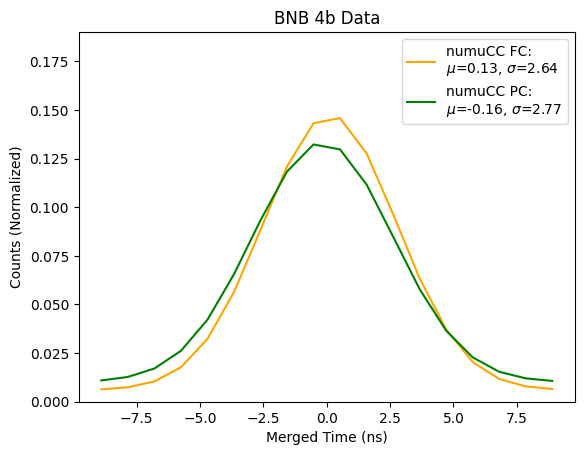

In [16]:
#plot the merged time distributions for numuCC events that are fully contained (FC) inside the dectector 
#compare this to events partially contained (PC) inside the detector

nbins = 18

data_numuCCFC = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and match_isFC==1")["merge_time"].to_numpy()
norm1 = len(data_numuCCFC)
y,xbins = np.histogram(data_numuCCFC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCC FC: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 18

data_numuCCPC = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and match_isFC==0")["merge_time"].to_numpy()
norm2 = len(data_numuCCPC)
y2,xbins = np.histogram(data_numuCCPC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("numuCC PC: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

NCpi0 Np: Gaussian      mean: -0.0953   std: 3.3592   C: 0.0045
NCpi0 0p: Gaussian      mean: -1.6325   std: 3.661   C: 0.0195


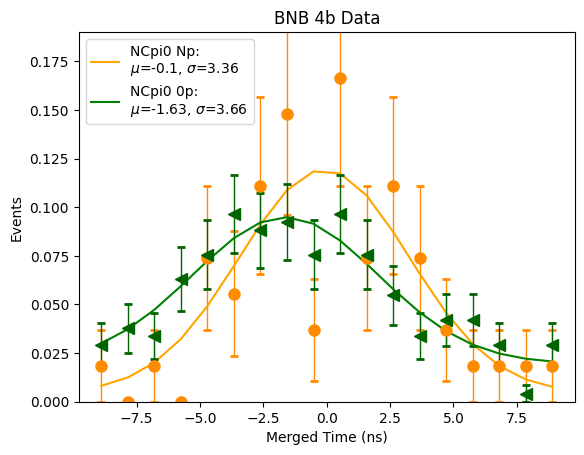

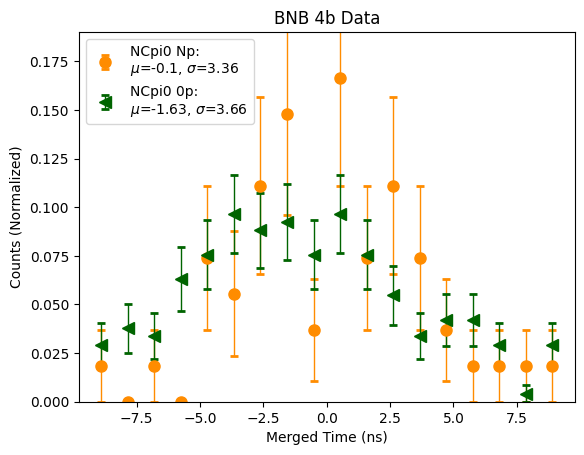

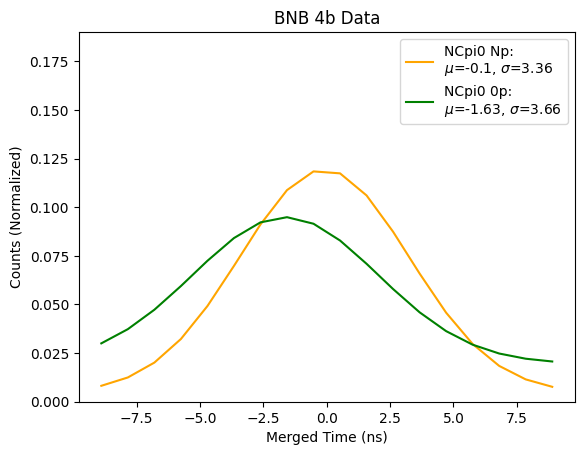

In [17]:
#plot the merged time distributions for NCpi0 events with a visible proton (Np)
#compare this to events without a visible proton (0p)

nbins = 18

data_NCpi0Np = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("reco_Eproton>35").query(NCpi0_query)["merge_time"].to_numpy()
norm1 = len(data_NCpi0Np)
y,xbins = np.histogram(data_NCpi0Np,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("NCpi0 Np: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

data_NCpi00p = data_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("reco_Eproton<35").query(NCpi0_query)["merge_time"].to_numpy()
norm2 = len(data_NCpi00p)
y2,xbins = np.histogram(data_NCpi00p,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("NCpi0 0p: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("BNB 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

In [18]:
#Add in the MC?

In [19]:
# Now do the same stuff, but for NuMI
f_data_run1 = uproot.open(numi_data_file)["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars_slim, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables, flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(["evtTimeNS","RWM_Time","PMT_Time"]+pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_vars_data, flatten=False)
f_data_run1B_pot = f_data_run1["T_pot"].pandas.df(["pot_tor875good","runNo",'subRunNo'], flatten=False)
data_run1B_pot = np.sum(f_data_run1B_pot["pot_tor875good"].to_numpy())
print(data_run1B_pot)
data_numi_run4b_super_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine

data_numi_run4b_super_df["rse_num"] = (data_numi_run4b_super_df["run"].to_numpy() * 100_000_000_000
                         + data_numi_run4b_super_df["subrun"].to_numpy() * 1_000_000
                         + data_numi_run4b_super_df["event"].to_numpy())

print(data_numi_run4b_super_df.shape[0])
data_numi_run4b_super_df = data_numi_run4b_super_df.drop_duplicates(subset=['rse_num'])
print(data_numi_run4b_super_df.shape[0])

#Set a variable saying this is not EXT data
data_numi_run4b_super_df["isEXT"] = [0 for i in range(data_numi_run4b_super_df.shape[0])]
#Set a variable saying this is not a dirt overlay
data_numi_run4b_super_df["isDirt"] = [0 for i in range(data_numi_run4b_super_df.shape[0])]
#Set a variable indicating the file type
data_numi_run4b_super_df["category"] = ["data" for i in range(data_numi_run4b_super_df.shape[0])]
#Set a vairable saying which run number this is.
#You can cut on this variable to do un by run comparisons.
data_numi_run4b_super_df["run_num"] = [2 for i in range(data_numi_run4b_super_df.shape[0])]

1349891.896221813
242390
241807


In [20]:
#Get the reconstructed neutrino energy
corrected_kine_reco_Enus = []
energy_info_lists = data_numi_run4b_super_df["kine_energy_info"].to_numpy()
energy_lists = data_numi_run4b_super_df["kine_energy_particle"].to_numpy()
pdg_lists = data_numi_run4b_super_df["kine_particle_type"].to_numpy()
add_energies = data_numi_run4b_super_df["kine_reco_add_energy"].to_numpy()
for i in tqdm(range(data_numi_run4b_super_df.shape[0])):
    corrected_kine_reco_Enu = 0.
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    energy_info_list = energy_info_lists[i]
    for j in range(len(energy_list)):
        if energy_info_list[j] == 2 and pdg_list[j] == 11:
            corrected_kine_reco_Enu += em_charge_scale * energy_list[j]
        else:
            corrected_kine_reco_Enu += energy_list[j]
    corrected_kine_reco_Enu += add_energies[i]
    
    corrected_kine_reco_Enus.append(corrected_kine_reco_Enu) 

data_numi_run4b_super_df["kine_reco_Enu"] = corrected_kine_reco_Enus

100%|███████████████████████████████| 241807/241807 [00:00<00:00, 407481.17it/s]


In [21]:
em_charge_scale = 0.95
data_numi_run4b_super_df["pio_mass"] = data_numi_run4b_super_df['kine_pio_mass'].to_numpy()* em_charge_scale
data_numi_run4b_super_df["em_charge_scale"] = np.ones_like(data_numi_run4b_super_df['kine_pio_mass'].to_numpy())* em_charge_scale

In [22]:
#get the muon and leading proton info out of the pfeval tree
mu0 = data_numi_run4b_super_df["reco_muonMomentum[0]"].to_numpy()
mu1 = data_numi_run4b_super_df["reco_muonMomentum[1]"].to_numpy()
mu2 = data_numi_run4b_super_df["reco_muonMomentum[2]"].to_numpy()
mu3 = data_numi_run4b_super_df["reco_muonMomentum[3]"].to_numpy()

p0 = data_numi_run4b_super_df["reco_protonMomentum[0]"].to_numpy()
p1 = data_numi_run4b_super_df["reco_protonMomentum[1]"].to_numpy()
p2 = data_numi_run4b_super_df["reco_protonMomentum[2]"].to_numpy()
p3 = data_numi_run4b_super_df["reco_protonMomentum[3]"].to_numpy()

kine_reco_Enu = data_numi_run4b_super_df["kine_reco_Enu"].to_numpy()

mu_thetas = []
mu_phis = []
mu_costhetas = []
mu_cosphis = []
reco_Emuon = []

p_thetas = []
p_phis = []
p_costhetas = []
p_cosphis = []
reco_Eproton = []

Ehadron = []

for i in range(len(mu3)):
    if(mu3[i]<=0): 
        mu_theta = np.nan
        mu_phi = np.nan
        Ehadron.append(kine_reco_Enu[i])
    else: 
        mu_theta, mu_phi = get_angle(mu0[i], mu1[i], mu2[i])
        Ehadron.append(kine_reco_Enu[i]-mu3[i]*1000)
    mu_thetas.append(mu_theta)
    mu_phis.append(mu_phi)
    mu_costhetas.append(np.cos(mu_theta))
    mu_cosphis.append(np.cos(mu_phi))
    reco_Emuon.append(mu3[i]*1000)
    
    if(p3[i]<=0): 
        p_theta = np.nan
        p_phi = np.nan
        reco_Eproton.append(0)
        
    else: 
        p_theta, p_phi = get_angle(p0[i], p1[i], p2[i])
        reco_Eproton.append(p3[i]*1000-938.27)
    p_thetas.append(p_theta)
    p_phis.append(p_phi)
    p_costhetas.append(np.cos(p_theta))
    p_cosphis.append(np.cos(p_phi))
    
    
    
    
    
data_numi_run4b_super_df["reco_muon_theta"] = mu_thetas
data_numi_run4b_super_df["reco_muon_phi"] = mu_phis
data_numi_run4b_super_df["reco_muon_costheta"] = mu_costhetas
data_numi_run4b_super_df["reco_muon_cosphi"] = mu_cosphis 
data_numi_run4b_super_df["reco_Emuon"] = reco_Emuon

data_numi_run4b_super_df["reco_proton_theta"] = p_thetas
data_numi_run4b_super_df["reco_proton_phi"] = p_phis
data_numi_run4b_super_df["reco_proton_costheta"] = p_costhetas
data_numi_run4b_super_df["reco_proton_cosphi"] = p_cosphis 
data_numi_run4b_super_df["reco_Eproton"] = reco_Eproton

data_numi_run4b_super_df["Ehadron"] = Ehadron

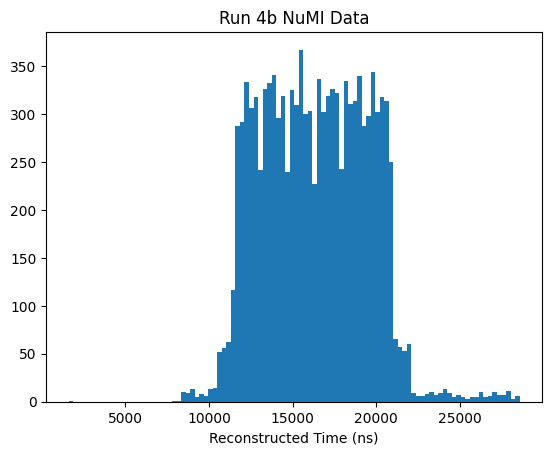

In [23]:
# Check the unmerged beamspill distribution
plt.figure()
plt.title("Run 4b NuMI Data")
plt.hist(data_numi_run4b_super_df.query("evtTimeNS>0")["evtTimeNS"].to_numpy(),bins=100)
plt.xlabel('Reconstructed Time (ns)')
plt.show()

In [26]:
evtTimeNS = data_numi_run4b_super_df["evtTimeNS"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):

    gap = numi_gap
    Shift=0.5
    TThelp=0

    TThelp = np.nan_to_num(evtTimeNS[i],nan=-9999)-Shift+gap*0.5
    TT_merged = -9999.
    
    if TThelp<0: 
        new_times.append(TT_merged)
        continue
        
    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)

data_numi_run4b_super_df["merge_time"] = new_times

numuCC: Gaussian      mean: 0.0104   std: 2.936   C: 0.0405
CCpi0: Gaussian      mean: 0.6868   std: 2.7272   C: 0.0432
NCpi0: Gaussian      mean: -2.2314   std: 2.6638   C: 0.057
loose nueCC: Gaussian      mean: -0.483   std: 2.5646   C: 0.0561


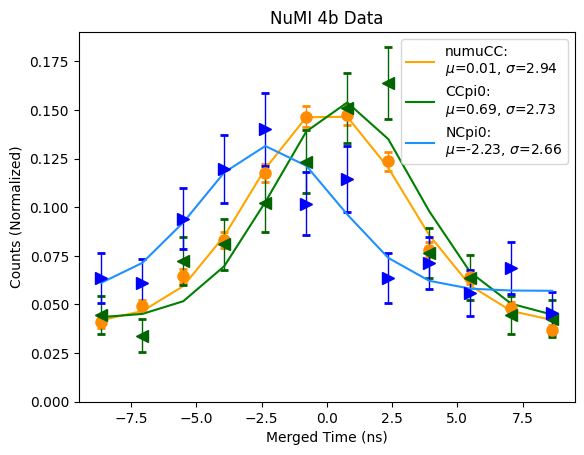

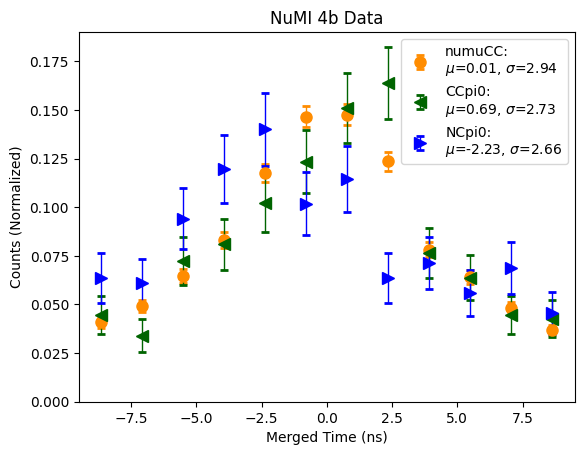

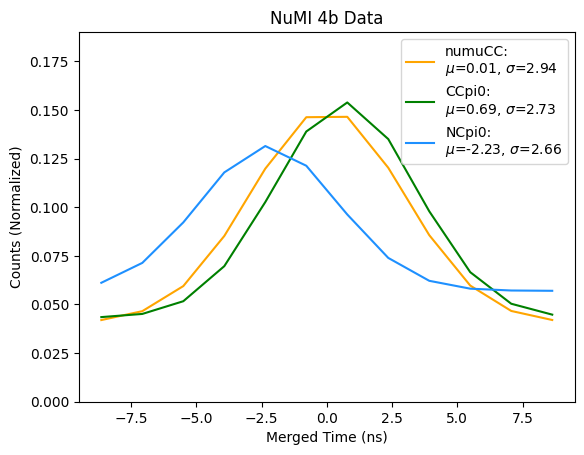

In [27]:
#plot the merged time distributions for numuCC events 
#compare this to CCpi0, NCpi0, and nueCC events

nbins = 12

data_numuCC = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9")["merge_time"].to_numpy()
norm1 = len(data_numuCC)
y,xbins = np.histogram(data_numuCC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)

x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCC: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 12

data_CCpi0 = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query(CCpi0_query)["merge_time"].to_numpy()
norm2 = len(data_CCpi0)
y2,xbins = np.histogram(data_CCpi0,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("CCpi0: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

nbins = 12

data_NCpi0 = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query(NCpi0_query)["merge_time"].to_numpy()
norm3 = len(data_NCpi0)
y3,xbins = np.histogram(data_NCpi0,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x3 = x
popt3,pcov3 = curve_fit(gaus,x,y3/norm3)
print("NCpi0: Gaussian      mean:",round(popt3[1],4),"  std:",round(popt3[2],4),"  C:",round(popt3[3],4))


data_nueCC = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("nue_score>2")["merge_time"].to_numpy()
norm4 = len(data_nueCC)
y4,xbins = np.histogram(data_nueCC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x4 = x
popt4,pcov4 = curve_fit(gaus,x,y4/norm4)
print("loose nueCC: Gaussian      mean:",round(popt4[1],4),"  std:",round(popt4[2],4),"  C:",round(popt4[3],4))


plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.errorbar(x3,y3/norm3,yerr=np.sqrt(y3)/norm3,ms=8, lw=1,fmt='>',ecolor = 'blue',color='blue', capsize=3, capthick=2)
plt.plot(x3,gaus(x3,*popt3),color='dodgerblue',label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.errorbar(x4,y4/norm4,yerr=np.sqrt(y4)/norm4,ms=8, lw=1,fmt='>',ecolor = 'magenta',color='magenta', capsize=3, capthick=2)
#plt.plot(x4,gaus(x4,*popt4),color='magenta',label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")


plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.ylim(0,0.19)
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.errorbar(x3,y3/norm3,yerr=np.sqrt(y3)/norm3,ms=8, lw=1,fmt='>',ecolor = 'blue',color='blue', capsize=3, capthick=2,label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.errorbar(x4,y4/norm4,yerr=np.sqrt(y4)/norm4,ms=8, lw=1,fmt='>',ecolor = 'magenta',color='magenta', capsize=3, capthick=2,label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.ylim(0,0.19)
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='CCpi0:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.plot(x3,gaus(x3,*popt3),color='dodgerblue',label='NCpi0:'+'\n'+f"$\mu$={round(popt3[1],2)}, $\sigma$={round(abs(popt3[2]),2)}")

#plt.plot(x4,gaus(x4,*popt4),color='magenta',label='loose nueCC:'+'\n'+f"$\mu$={round(popt4[1],2)}, $\sigma$={round(abs(popt4[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.ylim(0,0.19)
plt.show()

numuCCNp: Gaussian      mean: 0.1701   std: 2.7795   C: 0.0275
numuCC0p: Gaussian      mean: -0.1628   std: 3.1428   C: 0.0256


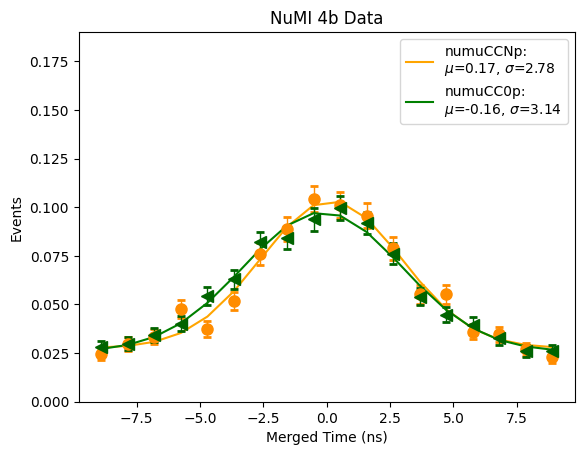

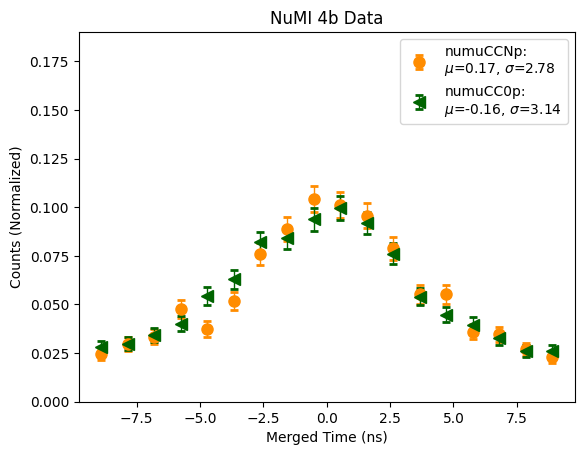

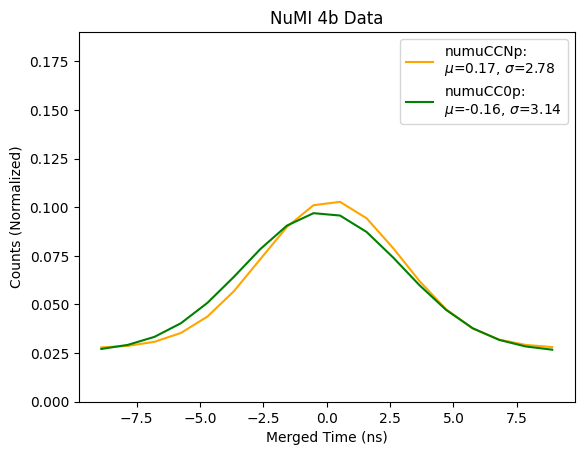

In [28]:
#plot the merged time distributions for numuCC events with a visible proton (Np)
#compare this to events without a visible proton (0p)

nbins = 18

data_numuCCNp = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and reco_Eproton>35")["merge_time"].to_numpy()
norm1 = len(data_numuCCNp)
y,xbins = np.histogram(data_numuCCNp,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCCNp: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 18

data_numuCC0p = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and reco_Eproton<35")["merge_time"].to_numpy()
norm2 = len(data_numuCC0p)
y2,xbins = np.histogram(data_numuCC0p,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("numuCC0p: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCCNp:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

numuCC FC: Gaussian      mean: -0.2929   std: 2.9316   C: 0.0258
numuCC PC: Gaussian      mean: 0.1256   std: 2.9151   C: 0.0276


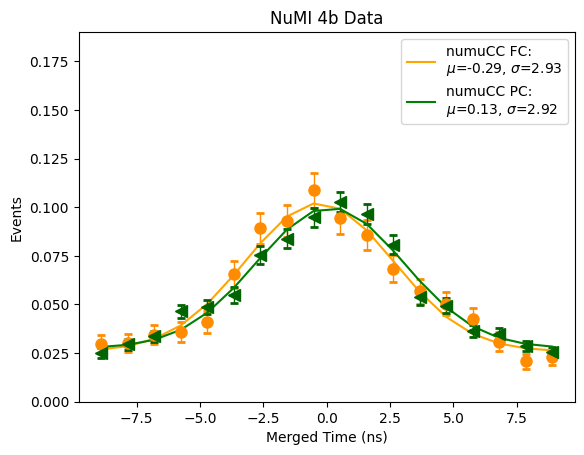

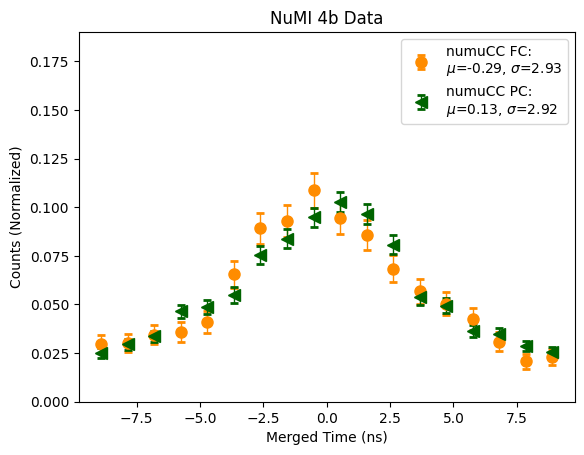

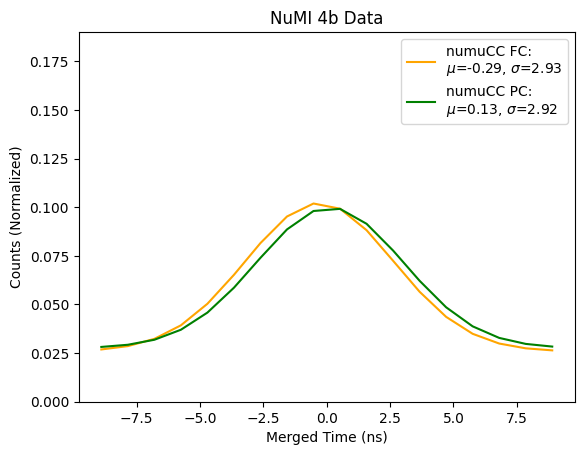

In [29]:
#plot the merged time distributions for numuCC events that are fully contained (FC) inside the dectector 
#compare this to events partially contained (PC) inside the detector

nbins = 18

data_numuCCFC = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and match_isFC==1")["merge_time"].to_numpy()
norm1 = len(data_numuCCFC)
y,xbins = np.histogram(data_numuCCFC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("numuCC FC: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 18

data_numuCCPC = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("numu_score>0.9 and match_isFC==0")["merge_time"].to_numpy()
norm2 = len(data_numuCCPC)
y2,xbins = np.histogram(data_numuCCPC,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("numuCC PC: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='numuCC FC:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='numuCC PC:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.19)
plt.legend()
plt.show()

NCpi0 Np: Gaussian      mean: -1.2658   std: 1.8289   C: 0.0812
NCpi0 0p: Gaussian      mean: -2.4821   std: 3.4069   C: 0.0781


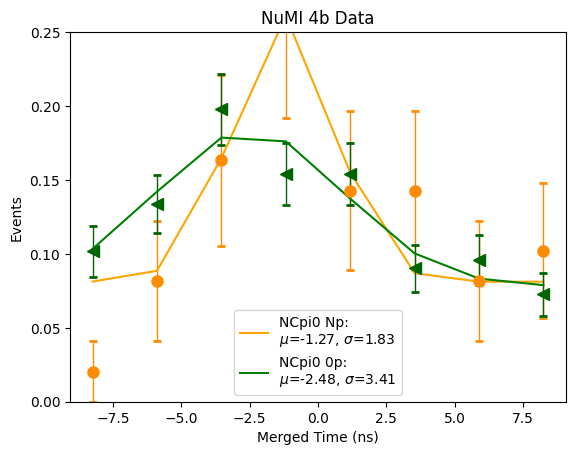

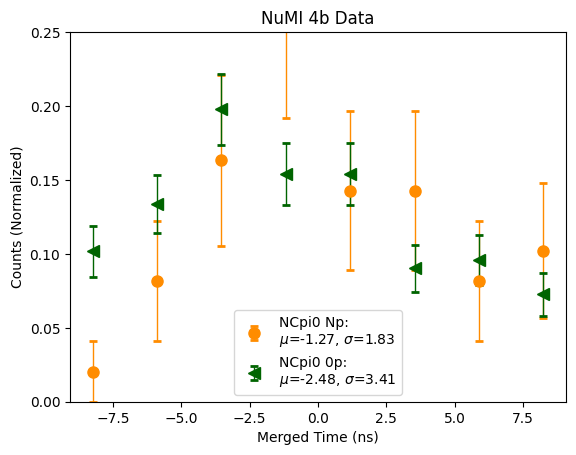

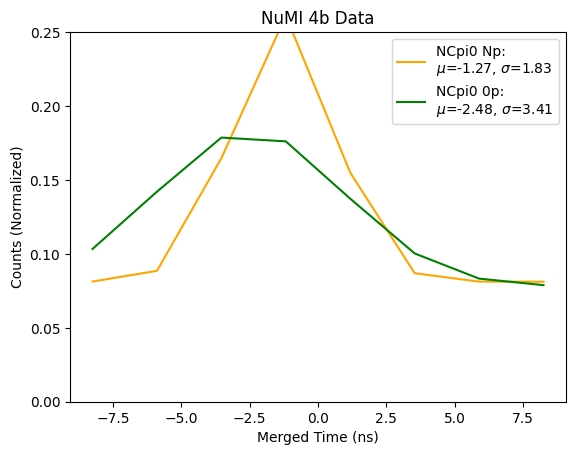

In [30]:
#plot the merged time distributions for NCpi0 events with a visible proton (Np)
#compare this to events without a visible proton (0p)

nbins = 8

data_NCpi0Np = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("reco_Eproton>35").query(NCpi0_query)["merge_time"].to_numpy()
norm1 = len(data_NCpi0Np)
y,xbins = np.histogram(data_NCpi0Np,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x1 = x
popt,pcov = curve_fit(gaus,x,y/norm1)
print("NCpi0 Np: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))

nbins = 8

data_NCpi00p = data_numi_run4b_super_df.query("merge_time>-9.42 and merge_time<9.42").query("reco_Eproton<35").query(NCpi0_query)["merge_time"].to_numpy()
norm2 = len(data_NCpi00p)
y2,xbins = np.histogram(data_NCpi00p,bins=nbins,range=(-9.42, 9.42))
x = get_bin_centers(xbins)
x2 = x
popt2,pcov2 = curve_fit(gaus,x,y2/norm2)
print("NCpi0 0p: Gaussian      mean:",round(popt2[1],4),"  std:",round(popt2[2],4),"  C:",round(popt2[3],4))

plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2)
plt.plot(x1,gaus(x1,*popt),color='orange',label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2)
plt.plot(x2,gaus(x2,*popt2),color='green',label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")


plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.25)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.errorbar(x1,y/norm1,yerr=np.sqrt(y)/norm1,ms=8, lw=1,fmt='o',ecolor = 'darkorange',color='darkorange', capsize=3, capthick=2,label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.errorbar(x2,y2/norm2,yerr=np.sqrt(y2)/norm2,ms=8, lw=1,fmt='<',ecolor = 'darkgreen',color='darkgreen', capsize=3, capthick=2,label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.25)
plt.legend()
plt.show()






plt.figure()
plt.title("NuMI 4b Data")
plt.plot(x1,gaus(x1,*popt),color='orange',label='NCpi0 Np:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")

plt.plot(x2,gaus(x2,*popt2),color='green',label='NCpi0 0p:'+'\n'+f"$\mu$={round(popt2[1],2)}, $\sigma$={round(abs(popt2[2]),2)}")

plt.ylabel("Counts (Normalized)")
plt.xlabel("Merged Time (ns)")
plt.ylim(0,0.25)
plt.legend()
plt.show()

In [31]:
#Add in the MC?

In [32]:
# It is also potentially usefull to look at how the mean and width of the distribution evolves as a function of some other variable

100%|██████████████████████████████████████| 292/292 [00:00<00:00, 68882.83it/s]


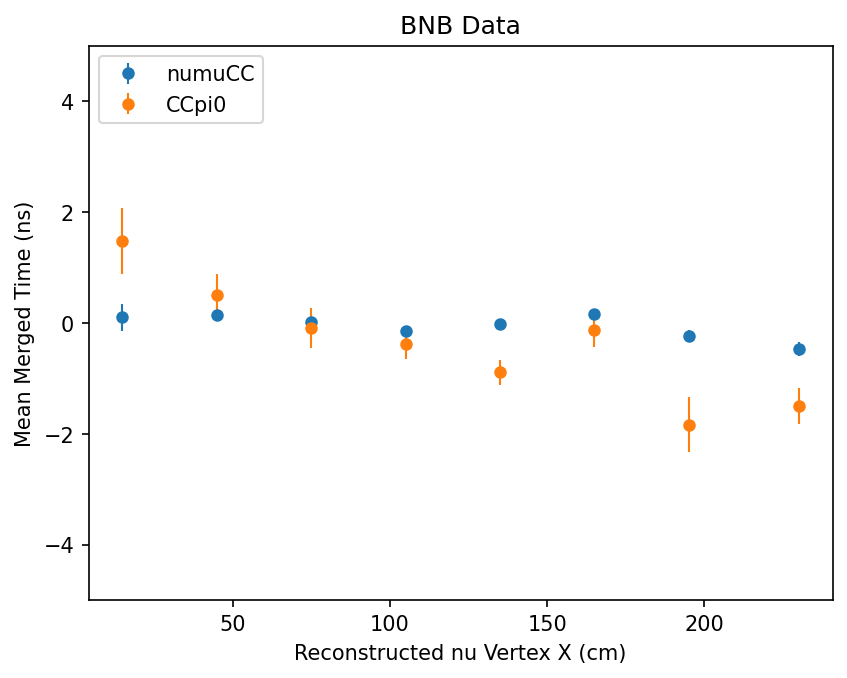

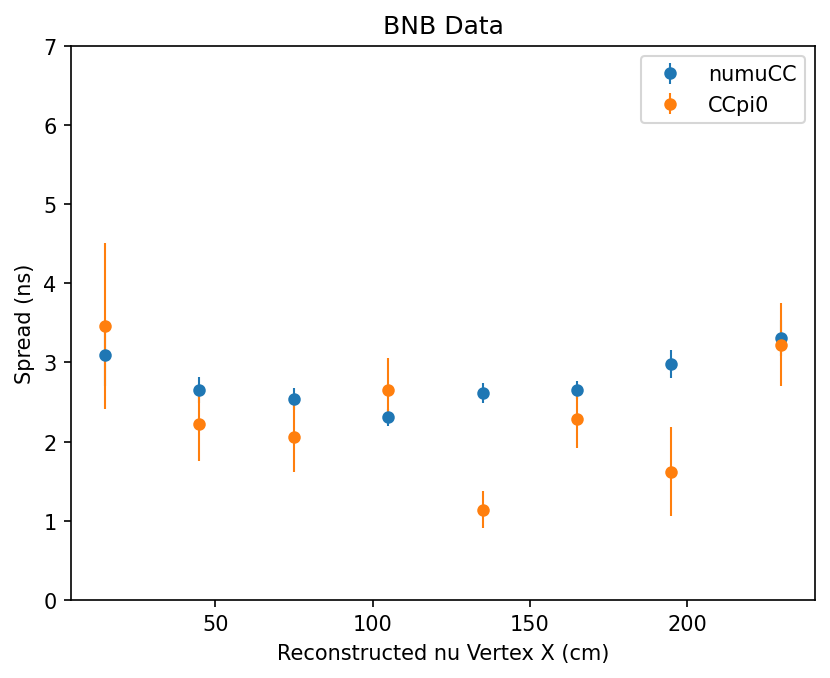

In [33]:

x_var = "reco_nuvtxX"
x_title = "Reconstructed nu Vertex X (cm)"
plot_title = "BNB Data"
bins = [0,30,60,90,120,150,180,210,250]
#bins = [0,50,100,150,200,250]

nbins = 18

means_numuCC = []
mean_errors_numuCC = []
stds_numuCC = []
std_errors_numuCC = []
global_query = "merge_time>-9.42 and merge_time<9.42 and numu_score>0.9"

xvar_full_list =  data_run4b_super_df.query(global_query)[x_var].to_numpy()
weight_list =  np.ones_like(data_run4b_super_df.query(global_query)[x_var].to_numpy())
merge_time =  data_run4b_super_df.query(global_query)["merge_time"].to_numpy()

data = []
data_weights = []
for i in range(len(bins)-1):
    data.append([])
    data_weights.append([])   

for event in tqdm(range(len(xvar_full_list))):
    for i in range(len(bins)-1):
        lo = bins[i]
        hi = 0
        if i==len(bins)-2: hi=1000000
        else: hi = bins[i+1]
        if(xvar_full_list[event]>=lo and xvar_full_list[event]<hi):
            data[i].append(merge_time[event])
            data_weights[i].append(weight_list[event])
        

    
for i in range(len(bins)-1):

    y,xbins = np.histogram(data[i],bins=nbins,range=(-9.42, 9.42),weights=data_weights[i])
    
    x = get_bin_centers(xbins)
    popt,pcov = curve_fit(gaus,x,y)
    means_numuCC.append(popt[1])
    stds_numuCC.append(abs(popt[2]))
    mean_errors_numuCC.append(np.sqrt(pcov[1][1]))
    std_errors_numuCC.append(np.sqrt(pcov[2][2]))



means_CCpi0 = []
mean_errors_CCpi0 = []
stds_CCpi0 = []
std_errors_CCpi0 = []
global_query = "merge_time>-9.42 and merge_time<9.42 and "+CCpi0_query

xvar_full_list =  data_run4b_super_df.query(global_query)[x_var].to_numpy()
weight_list =  np.ones_like(data_run4b_super_df.query(global_query)[x_var].to_numpy())
merge_time =  data_run4b_super_df.query(global_query)["merge_time"].to_numpy()

data = []
data_weights = []
for i in range(len(bins)-1):
    data.append([])
    data_weights.append([])   

for event in tqdm(range(len(xvar_full_list))):
    for i in range(len(bins)-1):
        lo = bins[i]
        hi = 0
        if i==len(bins)-2: hi=1000000
        else: hi = bins[i+1]
        if(xvar_full_list[event]>=lo and xvar_full_list[event]<hi):
            data[i].append(merge_time[event])
            data_weights[i].append(weight_list[event])

    
for i in range(len(bins)-1):

    y,xbins = np.histogram(data[i],bins=nbins,range=(-9.42, 9.42),weights=data_weights[i])
    
    x = get_bin_centers(xbins)
    popt,pcov = curve_fit(gaus,x,y)
    means_CCpi0.append(popt[1])
    stds_CCpi0.append(abs(popt[2]))
    mean_errors_CCpi0.append(np.sqrt(pcov[1][1]))
    std_errors_CCpi0.append(np.sqrt(pcov[2][2]))



means_NCpi0 = []
mean_errors_NCpi0 = []
stds_NCpi0 = []
std_errors_NCpi0 = []
global_query = "merge_time>-9.42 and merge_time<9.42 and "+NCpi0_query

xvar_full_list =  data_run4b_super_df.query(global_query)[x_var].to_numpy()
weight_list =  np.ones_like(data_run4b_super_df.query(global_query)[x_var].to_numpy())
merge_time =  data_run4b_super_df.query(global_query)["merge_time"].to_numpy()

data = []
data_weights = []
for i in range(len(bins)-1):
    data.append([])
    data_weights.append([])   

for event in tqdm(range(len(xvar_full_list))):
    for i in range(len(bins)-1):
        lo = bins[i]
        hi = 0
        if i==len(bins)-2: hi=1000000
        else: hi = bins[i+1]
        if(xvar_full_list[event]>=lo and xvar_full_list[event]<hi):
            data[i].append(merge_time[event])
            data_weights[i].append(weight_list[event])
        
    
for i in range(len(bins)-1):

    y,xbins = np.histogram(data[i],bins=nbins,range=(-9.42, 9.42),weights=data_weights[i])
    
    x = get_bin_centers(xbins)
    popt,pcov = curve_fit(gaus,x,y)
    means_NCpi0.append(popt[1])
    stds_NCpi0.append(abs(popt[2]))
    mean_errors_NCpi0.append(np.sqrt(pcov[1][1]))
    std_errors_NCpi0.append(np.sqrt(pcov[2][2]))


bin_centers = get_bin_centers(bins)
plt.figure(dpi=150)
plt.title(plot_title)
plt.errorbar(bin_centers,means_numuCC,yerr=mean_errors_numuCC,  lw=0,ms=5,marker="o",elinewidth=1,label="numuCC")
plt.errorbar(bin_centers,means_CCpi0,yerr=mean_errors_CCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="CCpi0")
#plt.errorbar(bin_centers,means_NCpi0,yerr=mean_errors_NCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="NCpi0")
plt.xlabel(x_title)
plt.ylim(-5,5)
plt.ylabel("Mean Merged Time (ns)")
plt.legend(loc='upper left')
plt.show()


plt.figure(dpi=150)
plt.title(plot_title)
plt.errorbar(bin_centers,stds_numuCC,yerr=std_errors_numuCC,  lw=0,ms=5,marker="o",elinewidth=1,label="numuCC")
plt.errorbar(bin_centers,stds_CCpi0,yerr=std_errors_CCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="CCpi0")
#plt.errorbar(bin_centers,stds_NCpi0,yerr=std_errors_NCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="NCpi0")
plt.xlabel(x_title)
plt.ylim(0,7)
plt.ylabel("Spread (ns)")
plt.legend()
plt.show()



100%|█████████████████████████████████████| 470/470 [00:00<00:00, 105047.58it/s]


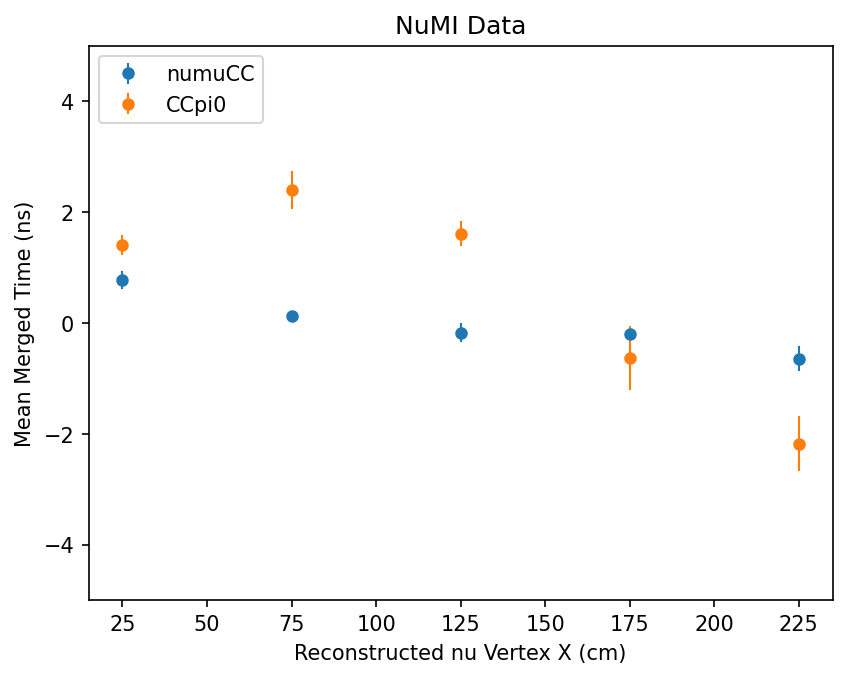

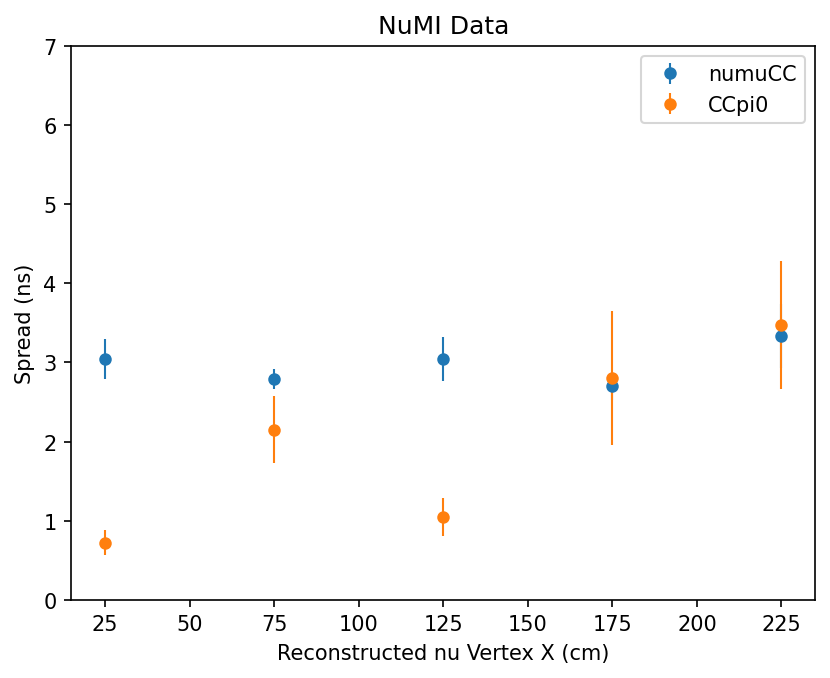

In [34]:

x_var = "reco_nuvtxX"
x_title = "Reconstructed nu Vertex X (cm)"
plot_title = "NuMI Data"
#bins = [0,30,60,90,120,150,180,210,250]
bins = [0,50,100,150,200,250]

nbins = 18

means_numuCC = []
mean_errors_numuCC = []
stds_numuCC = []
std_errors_numuCC = []
global_query = "merge_time>-9.42 and merge_time<9.42 and numu_score>0.9"

xvar_full_list =  data_numi_run4b_super_df.query(global_query)[x_var].to_numpy()
weight_list =  np.ones_like(data_numi_run4b_super_df.query(global_query)[x_var].to_numpy())
merge_time =  data_numi_run4b_super_df.query(global_query)["merge_time"].to_numpy()

data = []
data_weights = []
for i in range(len(bins)-1):
    data.append([])
    data_weights.append([])   

for event in tqdm(range(len(xvar_full_list))):
    for i in range(len(bins)-1):
        lo = bins[i]
        hi = 0
        if i==len(bins)-2: hi=1000000
        else: hi = bins[i+1]
        if(xvar_full_list[event]>=lo and xvar_full_list[event]<hi):
            data[i].append(merge_time[event])
            data_weights[i].append(weight_list[event])
        

    
for i in range(len(bins)-1):

    y,xbins = np.histogram(data[i],bins=nbins,range=(-9.42, 9.42),weights=data_weights[i])
    
    x = get_bin_centers(xbins)
    popt,pcov = curve_fit(gaus,x,y)
    means_numuCC.append(popt[1])
    stds_numuCC.append(abs(popt[2]))
    mean_errors_numuCC.append(np.sqrt(pcov[1][1]))
    std_errors_numuCC.append(np.sqrt(pcov[2][2]))



means_CCpi0 = []
mean_errors_CCpi0 = []
stds_CCpi0 = []
std_errors_CCpi0 = []
global_query = "merge_time>-9.42 and merge_time<9.42 and "+CCpi0_query

xvar_full_list =  data_numi_run4b_super_df.query(global_query)[x_var].to_numpy()
weight_list =  np.ones_like(data_numi_run4b_super_df.query(global_query)[x_var].to_numpy())
merge_time =  data_numi_run4b_super_df.query(global_query)["merge_time"].to_numpy()

data = []
data_weights = []
for i in range(len(bins)-1):
    data.append([])
    data_weights.append([])   

for event in tqdm(range(len(xvar_full_list))):
    for i in range(len(bins)-1):
        lo = bins[i]
        hi = 0
        if i==len(bins)-2: hi=1000000
        else: hi = bins[i+1]
        if(xvar_full_list[event]>=lo and xvar_full_list[event]<hi):
            data[i].append(merge_time[event])
            data_weights[i].append(weight_list[event])

    
for i in range(len(bins)-1):

    y,xbins = np.histogram(data[i],bins=nbins,range=(-9.42, 9.42),weights=data_weights[i])
    
    x = get_bin_centers(xbins)
    popt,pcov = curve_fit(gaus,x,y)
    means_CCpi0.append(popt[1])
    stds_CCpi0.append(abs(popt[2]))
    mean_errors_CCpi0.append(np.sqrt(pcov[1][1]))
    std_errors_CCpi0.append(np.sqrt(pcov[2][2]))





bin_centers = get_bin_centers(bins)
plt.figure(dpi=150)
plt.title(plot_title)
plt.errorbar(bin_centers,means_numuCC,yerr=mean_errors_numuCC,  lw=0,ms=5,marker="o",elinewidth=1,label="numuCC")
plt.errorbar(bin_centers,means_CCpi0,yerr=mean_errors_CCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="CCpi0")
plt.xlabel(x_title)
plt.ylim(-5,5)
plt.ylabel("Mean Merged Time (ns)")
plt.legend(loc='upper left')
plt.show()


plt.figure(dpi=150)
plt.title(plot_title)
plt.errorbar(bin_centers,stds_numuCC,yerr=std_errors_numuCC,  lw=0,ms=5,marker="o",elinewidth=1,label="numuCC")
plt.errorbar(bin_centers,stds_CCpi0,yerr=std_errors_CCpi0,  lw=0,ms=5,marker="o",elinewidth=1,label="CCpi0")
plt.xlabel(x_title)
plt.ylim(0,7)
plt.ylabel("Spread (ns)")
plt.legend()
plt.show()



In [35]:
#Extend this to data to MC comparisons as well?